In [1]:
from cgeniepy.ecology import EcoModel
import pandas as pd
from cgeniepy.array import GriddedData
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as colors

arc_mask = xr.load_dataarray("../masked_array.nc")

# model_path = Path("../model")

# ## list all folders containing "EXP1'
# exp1 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP1" in x.name]
# exp2 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP2" in x.name]
# exp3 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP3" in x.name]

m3 = EcoModel('../model/muffin.u067bc.PO4.EXP3', gemflag=['biogem', 'ecogem'])

def ocn_var_mean_change(model, variable, anomaly=True, timeslice=[2,3]):
    if anomaly:
        var0 = model.get_var(variable).isel(time=0).data * arc_mask
        var1 = model.get_var(variable).isel(time=timeslice).mean(dim=['time']).data * arc_mask
        diff = var1 - var0
        return GriddedData(diff, attrs=model.get_var(variable).attrs)
    else:
        var1 = model.get_var(variable).isel(time=timeslice).mean(dim=['time']).data * arc_mask
        return GriddedData(var1, attrs=model.get_var(variable).attrs)
    
##　use Helveticas
plt.rcParams['font.sans-serif'] = "Helvetica"

In [2]:
mld = ocn_var_mean_change(m3, 'phys_MLD', True).to_GriddedDataVis()
poc = ocn_var_mean_change(m3, 'bio_fpart_POC', True).isel(zt=0).to_GriddedDataVis()
ph = ocn_var_mean_change(m3, 'misc_pH', True).to_GriddedDataVis()
omega_cal= ocn_var_mean_change(m3, 'carb_ohm_cal', False).isel(zt=0)
omega_cal.attrs['units'] = 'unitless'
omega_cal = omega_cal.to_GriddedDataVis()
omega_ara = ocn_var_mean_change(m3, 'carb_ohm_arg', False).isel(zt=0)
omega_ara.attrs['units'] = 'unitless'
omega_ara = omega_ara.to_GriddedDataVis()

sst = ocn_var_mean_change(m3, 'ocn_sur_temp', True).to_GriddedDataVis()
po4 = ocn_var_mean_change(m3, 'ocn_sur_PO4', True).to_GriddedDataVis()

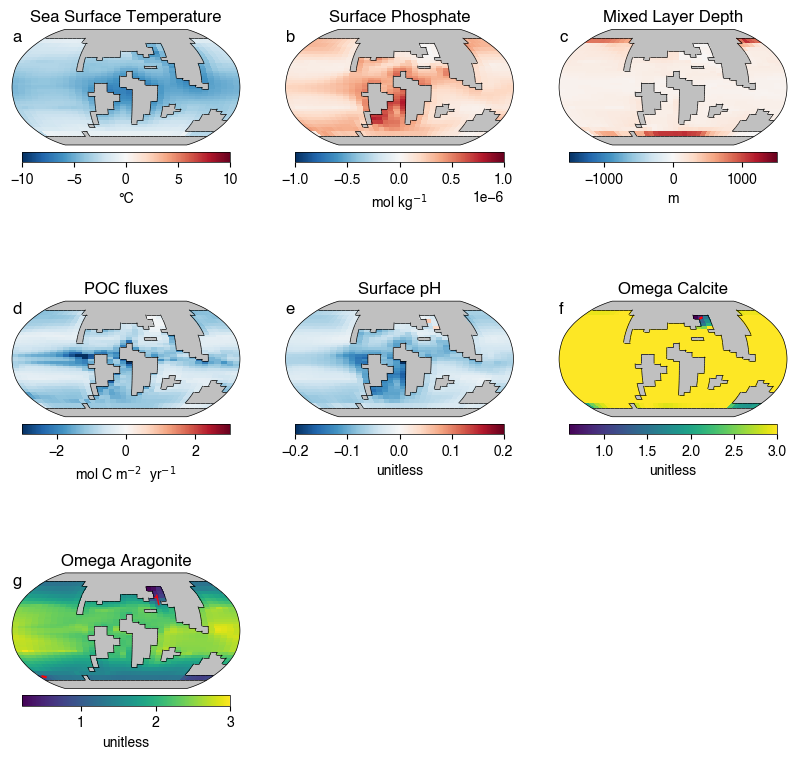

In [7]:
fig, axs = plt.subplots(3,3,figsize=(10, 10), subplot_kw={'projection': ccrs.Robinson()})

sst.aes_dict['pcolormesh_kwargs']['cmap'] = 'RdBu_r'
sst.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=10)
sst.aes_dict['colorbar_label_kwargs'] = {'label': '°C'}
sst.plot(ax=axs[0,0], outline=True, colorbar=True)


po4.aes_dict['pcolormesh_kwargs']['cmap'] = 'RdBu_r'
po4.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=1E-6)
po4.aes_dict['colorbar_label_kwargs'] = {'label': 'mol kg$^{-1}$'}
po4.plot(ax=axs[0,1], outline=True, colorbar=True)

mld.aes_dict['pcolormesh_kwargs']['cmap'] = 'RdBu_r'
mld.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=1500)
mld.aes_dict['colorbar_label_kwargs'] = {'label': 'm'}
mld.plot(ax=axs[0,2], outline=True, colorbar=True)

poc.aes_dict['pcolormesh_kwargs']['cmap'] = 'RdBu_r'
poc.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=3)
poc.aes_dict['colorbar_label_kwargs'] = {'label': r'mol C m$^{-2}$  yr$^{-1}$'}
poc.plot(ax=axs[1,0], outline=True, colorbar=True)

ph.aes_dict['pcolormesh_kwargs']['cmap'] = 'RdBu_r'
ph.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=0.2)
ph.aes_dict['colorbar_label_kwargs'] = {'label': 'unitless'}
ph.plot(ax=axs[1,1], outline=True, colorbar=True)


omega_cal.aes_dict['pcolormesh_kwargs']['cmap'] = 'viridis'
omega_cal.aes_dict['pcolormesh_kwargs']['vmax'] = 3
omega_cal.aes_dict['colorbar_label_kwargs'] = {'label': 'unitless'}
omega_cal.aes_dict['contour_kwargs'] = {'levels': [1], 'colors': 'red'}
omega_cal.aes_dict['contour_label_kwargs'] = {'colors': 'red'}
omega_cal.plot(ax=axs[1,2], outline=True, colorbar=True, contour=True)


## add a contour ofr omega
omega_ara.aes_dict['pcolormesh_kwargs']['cmap'] = 'viridis'
omega_ara.aes_dict['pcolormesh_kwargs']['vmax'] = 3
omega_ara.aes_dict['colorbar_label_kwargs'] = {'label': 'unitless'}
omega_ara.aes_dict['contour_kwargs'] = {'levels': [1], 'colors': 'red'}
omega_ara.aes_dict['contour_label_kwargs'] = {'colors': 'red'}

omega_ara.plot(ax=axs[2,0], outline=True, colorbar=True, contour=True)

## add alphabetic labels for each subplot
for i, ax in enumerate(axs.flat):
    ax.text(0, 1.0, chr(97+i), transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
## add title for each subplot
axs[0,0].set_title('Sea Surface Temperature')
axs[0,1].set_title('Surface Phosphate')
axs[0,2].set_title('Mixed Layer Depth')
axs[1,0].set_title('POC fluxes')
axs[1,1].set_title('Surface pH')
axs[1,2].set_title('Omega Calcite')
axs[2,0].set_title('Omega Aragonite')

## remove last subplot
fig.delaxes(axs[2,1])
fig.delaxes(axs[2,2])
fig.savefig('../output/env_change_map.png', dpi=300, bbox_inches='tight')

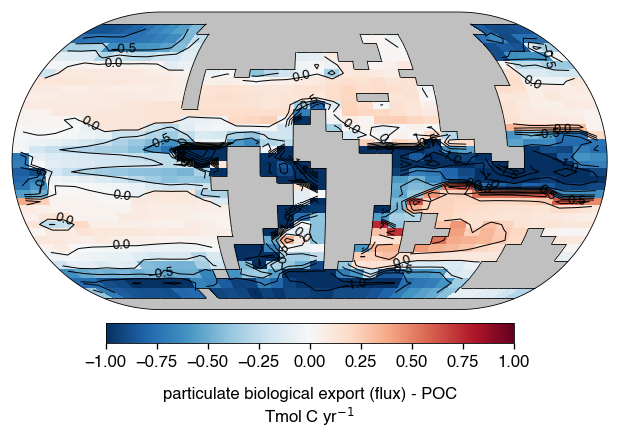

In [23]:
poc_anomaly = ocn_var_mean_change(m3, variable='bio_fexport_POC', timeslice=[-1])
poc_anomaly.data = poc_anomaly.data/1e12
poc_anomaly.attrs['units'] = 'Tmol C yr$^{-1}$'

poc_anomaly.plot(cmap='RdBu_r',colorbar=True, outline=True, vmin=-1, vmax=1,contour=True, levels=[0], contour_label=True)
plt.savefig('../output/poc_diff.png', dpi=300, bbox_inches='tight')

In [4]:
# ## export for EXP4/5
# import numpy as np

# ## convert celsius to kelvin
# sst = ocn_var_change(m3, 'ocn_sur_temp', 0)
# sst_kelvin = sst.array.values + 273.15
# ## round to 2 decimal places
# ## replace na with 1E-5
# np.nan_to_num(sst_kelvin, copy=False, nan=1E-5)
# np.savetxt('../data/muffin.u067bc.PO4.SST.txt', sst_kelvin, fmt='%.2f', delimiter='\t')

# #PARfrac * dum_egbg_fxsw(:,:)
# fxsw = ocn_var_change(m3, 'phys_fxsw', 0)
# par_frac = 0.43
# par = fxsw * par_frac

# np.savetxt('../data/muffin.u067bc.PO4.PAR.txt', par.array.values, fmt='%.2f', delimiter='\t')